In [1]:
import numpy as np

from skimage import io
from skimage.util import img_as_float
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

import matplotlib.pyplot as plt
%matplotlib inline

# Splitting Image Into Superpixels

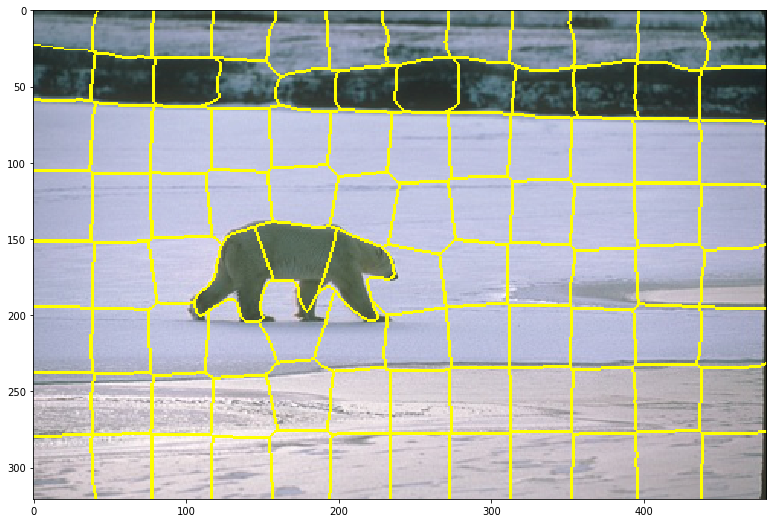

In [2]:
image = io.imread('./data/100007.jpg')
image = img_as_float(image)

segments = slic(image, n_segments=100, compactness=40, max_iter=10, sigma=3, convert2lab=True)

fig = plt.figure(figsize = (16, 9))
plt.imshow(mark_boundaries(image, segments))
plt.axis("on")
plt.show()

# Prior Label Information Setting Up

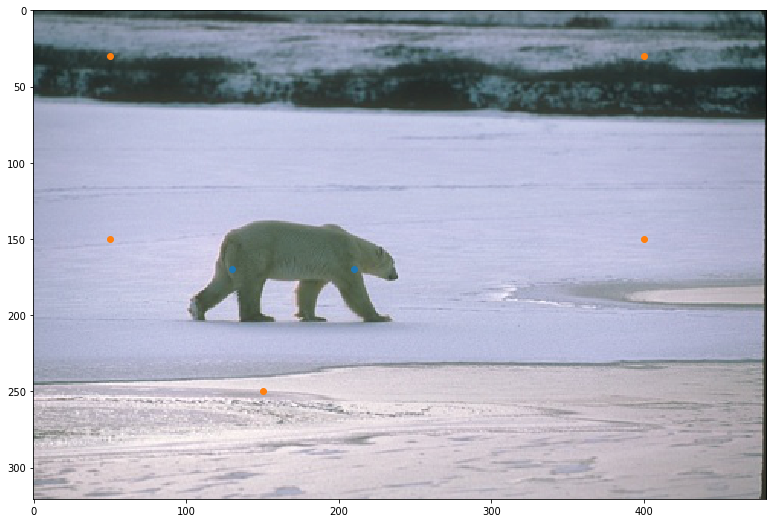

In [3]:
foreground_pixels = np.array([[170, 130], [170, 210]])
background_pixels = np.array([[30, 50], [30, 400], [250, 150], [150, 400], [150, 50]]) # 100007

fig = plt.figure(figsize = (16, 9))
plt.imshow(image)
plt.scatter(foreground_pixels[:, 1], foreground_pixels[:, 0])
plt.scatter(background_pixels[:, 1], background_pixels[:, 0])
plt.axis("on")
plt.show()

### Prior label constraints

In [4]:
from utils import prior_label_constraints
l, u = prior_label_constraints(segments, foreground_pixels, background_pixels)

# Laplacian Matrix For Graph Based On Image Superpixels

In [51]:
from utils import Laplacian
L = Laplacian(image, segments, 'unnormalized')

# Results Visualization

In [52]:
from utils import get_binary_mask, mask_overlay

## SDP Relaxation

In [53]:
from sdp import SDP_relaxation
x_opt, _ = SDP_relaxation(L, l, u, options={'maxiter': 100, 'disp': True})

Function value: 1633.813556418922
Iterations number: 99


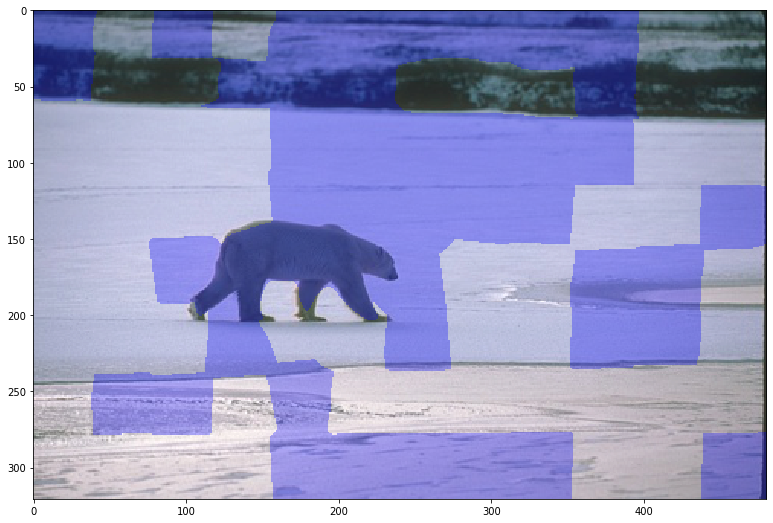

In [54]:
binary_mask = get_binary_mask(segments, x_opt)

plt.figure(figsize=(16, 9))
plt.imshow(mask_overlay(image, binary_mask, color=[0, 0, 1]));

## MPEC-EPM

In [55]:
from mpec import MPEC_EPM
x_opt, _ = MPEC_EPM(L, l, u, options={'maxiter': 20, 'disp': True})

Function value: 55.384392148517605
Iterations number: 20


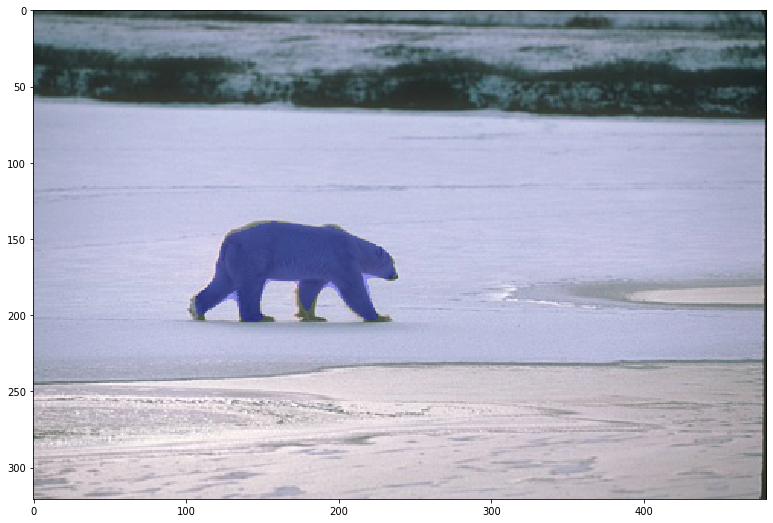

In [56]:
binary_mask = get_binary_mask(segments, x_opt)

plt.figure(figsize=(16, 9))
plt.imshow(mask_overlay(image, binary_mask, color=[0, 0, 1]));

# Original MPEC-EPM

In [11]:
from mpec import original_MPEC_EPM
x_opt, _ = original_MPEC_EPM(L, k=10, options={'maxiter': 100, 'disp': True})

Function value: 728.8739968802278
Iterations number: 93


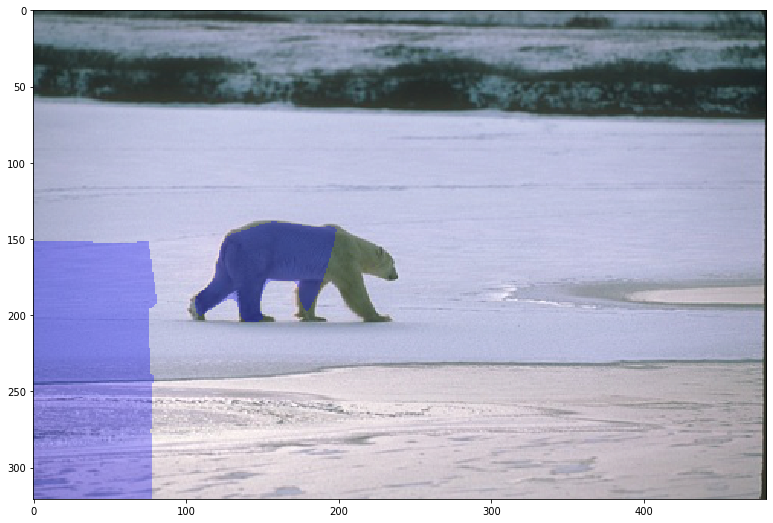

In [12]:
binary_mask = get_binary_mask(segments, x_opt)

plt.figure(figsize=(16, 9))
plt.imshow(mask_overlay(image, binary_mask, color=[0, 0, 1]));

# Different metrics for graph building

We tested different approaces for building Laplacian matrix from superpixels of image.

* L2-norm
$$
d(i, j) = ||x_i - x_j||_2^2,
$$
where $i$, $j$ - number of corresponding superpixels, $x_i$ - features of superpixel $i$ (R,G,B, x, y)

* Exponential
$$
d(i, j) = e^{-||x^{RGB}_i-x^{RGB}_j||^2_2/\sigma_w} \cdot e^{-||x^{r}_i-x^{r}_j||^2_2/\sigma_r},
$$
where first term is responsible for color difference, and the second term  - for spatial difference. $\sigma_w$ and $\sigma_r$ - special smoothing factors.

* Manhattan
$$
d(i, j) = ||x_i - x_j||_1,
$$

Comparison of these methods is given below. 

Function value: 23565.52220168683
Iterations number: 19
Function value: 233.48458020223995
Iterations number: 81
Function value: 478.9363664785459
Iterations number: 19
Function value: 89.34857311086974
Iterations number: 61
Function value: 1643.2802560794653
Iterations number: 19
Function value: 55.384392148517605
Iterations number: 63


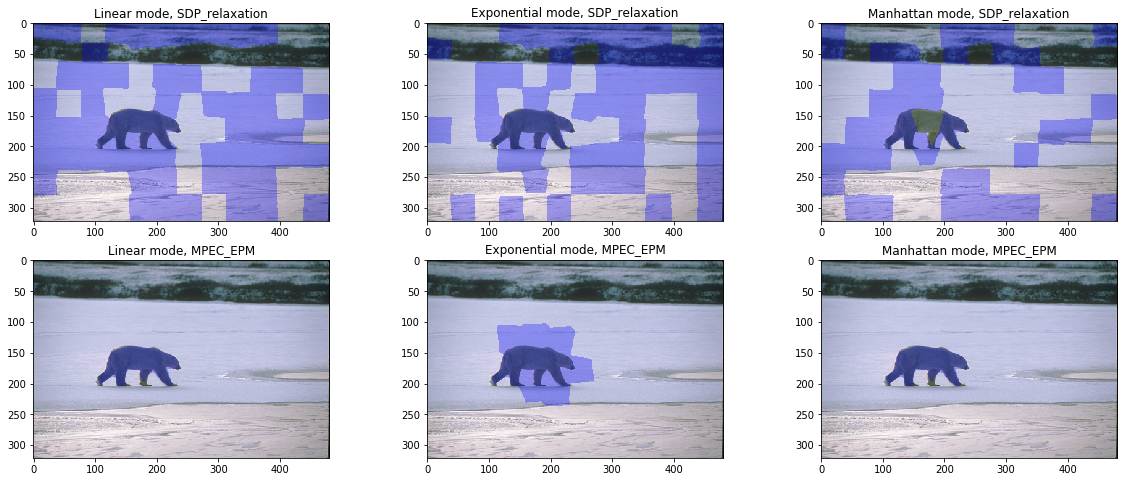

In [67]:
plt.figure(figsize=(20, 8))

modes = ['linear', 'exponential', 'manhattan']
algs = [SDP_relaxation, MPEC_EPM]
maxiters = [20, 100]

for i, mode in enumerate(modes):
    for j, alg in enumerate(algs):
        plt.subplot(2, 3, i+j*3+1)
        L = Laplacian(image, segments, 'unnormalized', mode=modes[i])
        x_opt, _ = alg(L, l, u, options={'maxiter': maxiters[j], 'disp': True})
        binary_mask = get_binary_mask(segments, x_opt)

        plt.imshow(mask_overlay(image, binary_mask, color=[0, 0, 1]))
        plt.title('{} mode, {}'.format(modes[i].capitalize(), algs[j].__name__))

We have not got any significant difference between these method both in terms of visuality, and in terms of optimization value. 
Further we use just L2-norm method.

# Test On Different Images

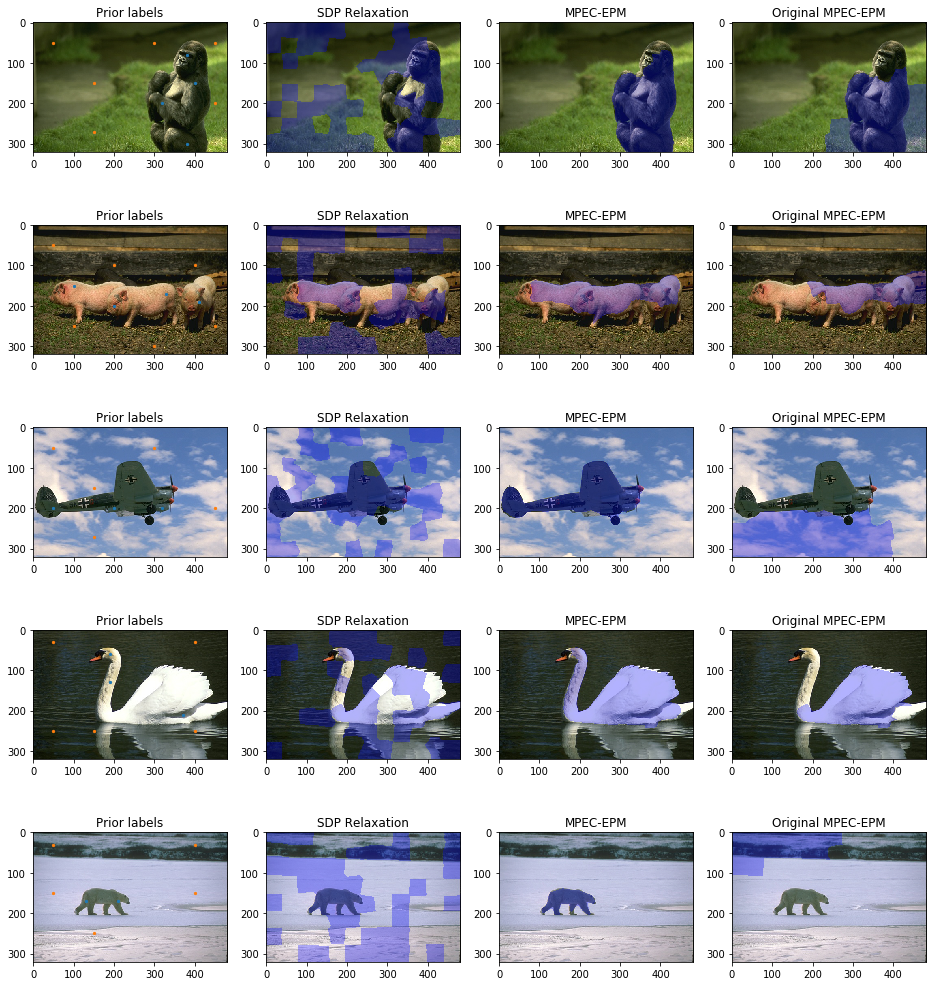

In [13]:
F = []
B = []
images = ['./data/49024.jpg', './data/66053.jpg', './data/3063.jpg', './data/8068.jpg', './data/100007.jpg']

foreground_pixels = np.array([[80, 380], [150, 400], [200, 320], [300, 380]])
background_pixels = np.array([[50, 50], [150, 150], [270, 150], [200, 450], [50, 450], [50, 300]]) # 49024
F.append(foreground_pixels)
B.append(background_pixels)

foreground_pixels = np.array([[150, 100], [200, 200], [170, 330], [190, 410]])
background_pixels = np.array([[50, 50], [100, 200], [250, 100], [300, 300], [250, 450], [100, 400]]) # 66053
F.append(foreground_pixels)
B.append(background_pixels)

foreground_pixels = np.array([[200, 50], [200, 320], [200, 200]])
background_pixels = np.array([[50, 50], [150, 150], [270, 150], [200, 450], [50, 300]]) # 3063
F.append(foreground_pixels)
B.append(background_pixels)

foreground_pixels = np.array([[60, 190], [130, 190], [210, 370]])
background_pixels = np.array([[30, 50], [30, 400], [250, 150], [250, 400], [250, 50]]) # 8068
F.append(foreground_pixels)
B.append(background_pixels)

foreground_pixels = np.array([[170, 130], [170, 210]])
background_pixels = np.array([[30, 50], [30, 400], [250, 150], [150, 400], [150, 50]]) # 100007
F.append(foreground_pixels)
B.append(background_pixels)

fig, axes = plt.subplots(ncols=4, nrows=5, figsize=(16, 18))
for i, (image_filename, foreground_pixels, background_pixels) in enumerate(zip(images, F, B)):
    image = io.imread(image_filename)
    image = img_as_float(image)
    segments = slic(image, n_segments=100, compactness=40, max_iter=10, sigma=3, convert2lab=True)
    
    l, u = prior_label_constraints(segments, foreground_pixels, background_pixels)
    L = Laplacian(image, segments, 'unnormalized')
    
    axes[i, 0].imshow(image)
    axes[i, 0].scatter(foreground_pixels[:, 1], foreground_pixels[:, 0], s=5.0)
    axes[i, 0].scatter(background_pixels[:, 1], background_pixels[:, 0], s=5.0)
    axes[i, 0].set_title('Prior labels')
    
    x_opt, _ = SDP_relaxation(L, l, u, options={'maxiter': 100, 'disp': False})
    binary_mask = get_binary_mask(segments, x_opt)
    axes[i, 1].imshow(mask_overlay(image, binary_mask, color=[0, 0, 1]))
    axes[i, 1].set_title('SDP Relaxation')

    x_opt, _ = MPEC_EPM(L, l, u, options={'maxiter': 20, 'disp': False})
    binary_mask = get_binary_mask(segments, x_opt)
    axes[i, 2].imshow(mask_overlay(image, binary_mask, color=[0, 0, 1]))
    axes[i, 2].set_title('MPEC-EPM')
    
    f_best = np.inf
    for k in range(10, 31, 1):
        x, f = original_MPEC_EPM(L, k, options={'maxiter': 100, 'disp': False})
        if f < f_best:
            f_best = f
            x_opt = x
    binary_mask = get_binary_mask(segments, x_opt)
    axes[i, 3].imshow(mask_overlay(image, binary_mask, color=[0, 0, 1]))
    axes[i, 3].set_title('Original MPEC-EPM')

fig.savefig('results.jpg', dpi=fig.dpi)
plt.show()

# References

[1] Yuan, Ganzhao & Ghanem, Bernard. [Binary Optimization via Mathematical Programming with Equilibrium Constraints](https://www.researchgate.net/publication/306226162_Binary_Optimization_via_Mathematical_Programming_with_Equilibrium_Constraints), 2016.

[2] Keuchel, Jens & Schnörr, Christoph & Schellewald, Christian & Cremers, Daniel. [Binary Partitioning, Perceptual Grouping, and Restoration with Semidefinite Programming](https://www.researchgate.net/publication/3193618_Binary_Partitioning_Perceptual_Grouping_and_Restoration_with_Semidefinite_Programming). Pattern Analysis and Machine Intelligence, IEEE Transactions on. 25. 1364- 1379, 2003. doi:10.1109/TPAMI.2003.1240111.

[3] Han, Congying & Li, Mingqiang & Zhao, Tong & Guo, Tiande. [An Accelerated Proximal Gradient Algorithm for Singly Linearly Constrained Quadratic Programs with Box Constraints](https://www.researchgate.net/publication/258503776_An_Accelerated_Proximal_Gradient_Algorithm_for_Singly_Linearly_Constrained_Quadratic_Programs_with_Box_Constraints). TheScientificWorldJournal, 2013. doi:10.1155/2013/246596

[4] Dai, Yu-Hong & Fletcher, Roger. [New algorithms for singly linearly constrained quadratic programs subject to lower and upper bounds](https://www.researchgate.net/publication/220589208_New_algorithms_for_singly_linearly_constrained_quadratic_programs_subject_to_lower_and_upper_bounds). Math. Program.. 106. 403-421, 2006. doi:10.1007/s10107-005-0595-2

[5] Helgason, R., Kennington, J., & Lall, H. [A polynomially bounded algorithm for a singly constrained quadratic program. Mathematical Programming](https://link.springer.com/article/10.1007/BF01588328), 18(1), 338–343, 1980. doi:10.1007/bf01588328

[6] Achanta, Radhakrishna & Shaji, Appu & Smith, Kevin & Lucchi, Aurélien & Fua, Pascal & Süsstrunk, Sabine. [SLIC superpixels](https://www.researchgate.net/publication/44234783_SLIC_superpixels). 2010. Technical report, EPFL.

[7] Achanta, Radhakrishna & Shaji, Appu & Smith, Kevin & Lucchi, Aurélien & Fua, Pascal & Susstrunk, Sabine. [SLIC Superpixels Compared to State-of-the-Art Superpixel Methods](https://www.researchgate.net/publication/225069465_SLIC_Superpixels_Compared_to_State-of-the-Art_Superpixel_Methods). IEEE transactions on pattern analysis and machine intelligence. 34, 2012. doi:10.1109/TPAMI.2012.120